# Загрузка данных

Импорт и установка библиотек

In [1]:
!pip install pmdarima

import pickle
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error


warnings.filterwarnings("ignore")
%matplotlib inline

Выберите способ загрузки данных

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

In [3]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [4]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [6]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [7]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [8]:
df_ts.shape

(400, 2)

### Визуализация

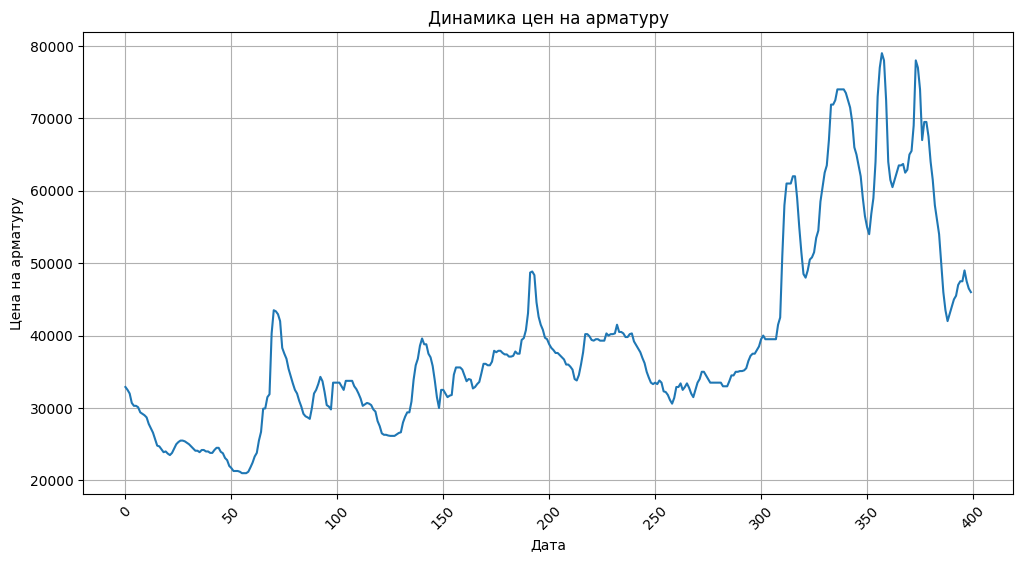

In [9]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

In [ ]:
# Декомпозиция временного ряда
decompose = seasonal_decompose(df_ts['Цена на арматуру'], period=52, extrapolate_trend=False)

# 1. Восстановление тренда с помощью SARIMA
trend_filled = decompose.trend.fillna(method='ffill')  # Заполняем пропуски временно, чтобы обучить модель
model_trend = SARIMAX(trend_filled, order=(3,1,3), seasonal_order=(1,1,1,52))
result_trend = model_trend.fit()

# Предсказание тренда на весь диапазон данных
trend_pred = result_trend.predict(start=trend_filled.index[0], end=trend_filled.index[-1])

# Вставляем предсказанные значения вместо NaN
trend_recovered = decompose.trend.copy()
trend_recovered.loc[trend_recovered.isna()] = trend_pred[trend_recovered.isna()]

# 2. Восстановление шума с помощью RandomForest
residuals = decompose.resid.copy()

# Разделяем известные и пропущенные значения
known_idx = residuals.dropna().index
missing_idx = residuals[residuals.isna()].index

# Обучаем RandomForest на известных значениях шума
X_train = np.array(known_idx).reshape(-1, 1)
y_train = residuals.dropna().values

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Восстанавливаем пропущенные значения
X_pred = np.array(missing_idx).reshape(-1, 1)
residuals.loc[missing_idx] = rf_model.predict(X_pred)

# 3. Восстановление полного временного ряда
df_ts['Восстановленный ряд'] = trend_recovered + decompose.seasonal + residuals

# 4. Визуализация
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# Оригинальный ряд
df_ts['Цена на арматуру'].plot(ax=axes[0], title='Оригинальный временной ряд')
# Восстановленный тренд
trend_recovered.plot(ax=axes[1], title='Восстановленный тренд')
# Сезонность (она неизменна)
decompose.seasonal.plot(ax=axes[2], title='Сезонность')
# Восстановленный шум
residuals.plot(ax=axes[3], title='Восстановленный шум')

plt.tight_layout()
plt.show()

# Сравнение оригинального и восстановленного ряда
plt.figure(figsize=(14,6))
plt.plot(df_ts['Цена на арматуру'], label="Оригинальный ряд", linestyle="dashed")
plt.plot(df_ts['Восстановленный ряд'], label="Восстановленный ряд", color='red')
plt.legend()
plt.title("Сравнение оригинального и восстановленного ряда")
plt.show()

### тест вариант

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Декомпозиция временного ряда
decompose = seasonal_decompose(df_ts['Цена на арматуру'], period=52, extrapolate_trend=False)

# 1. Восстановление тренда с помощью SARIMA
trend_filled = trend_filled.fillna(method='ffill').fillna(method='bfill') # Заполняем пропуски временно, чтобы обучить модель

# Подбор оптимальных параметров SARIMA
auto_model = auto_arima(trend_filled, seasonal=True, m=52,
                        stepwise=True, trace=True,
                        suppress_warnings=True,
                        error_action="ignore", max_order=20)

# Используем найденные параметры
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

# Обучаем SARIMA с лучшими параметрами
model_trend = SARIMAX(trend_filled, order=best_order, seasonal_order=best_seasonal_order)
result_trend = model_trend.fit()

# Предсказание тренда
trend_pred = result_trend.predict(start=trend_filled.index[0], end=trend_filled.index[-1])

# Вставляем предсказанные значения вместо NaN
trend_recovered = decompose.trend.copy()
trend_recovered.loc[trend_recovered.isna()] = trend_pred[trend_recovered.isna()]

# 2. Восстановление шума с помощью RandomForest
residuals = decompose.resid.copy()

# Разделяем известные и пропущенные значения
known_idx = residuals.dropna().index
missing_idx = residuals[residuals.isna()].index

# Обучаем RandomForest на известных значениях шума
X_train = np.array(known_idx).reshape(-1, 1)
y_train = residuals.dropna().values

# Подбор гиперпараметров RandomForest через GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Используем лучшую модель
best_rf_model = grid_search.best_estimator_

# Восстанавливаем пропущенные значения
X_pred = np.array(missing_idx).reshape(-1, 1)
residuals.loc[missing_idx] = best_rf_model.predict(X_pred)

# 3. Восстановление полного временного ряда
df_ts['Восстановленный ряд'] = trend_recovered + decompose.seasonal + residuals

# 4. Визуализация
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# Оригинальный ряд
df_ts['Цена на арматуру'].plot(ax=axes[0], title='Оригинальный временной ряд')
# Восстановленный тренд
trend_recovered.plot(ax=axes[1], title='Восстановленный тренд')
# Сезонность (она неизменна)
decompose.seasonal.plot(ax=axes[2], title='Сезонность')
# Восстановленный шум
residuals.plot(ax=axes[3], title='Восстановленный шум')

plt.tight_layout()
plt.show()

# Сравнение оригинального и восстановленного ряда
plt.figure(figsize=(14,6))
plt.plot(df_ts['Цена на арматуру'], label="Оригинальный ряд", linestyle="dashed")
plt.plot(df_ts['Восстановленный ряд'], label="Восстановленный ряд", color='red')
plt.legend()
plt.title("Сравнение оригинального и восстановленного ряда")
plt.show()

### Работа с автокорреляцией

In [ ]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

In [ ]:
# Визуализация автокорреляции

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

In [ ]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

In [ ]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")

# Боксплот
plt.subplot(1, 2, 2)
sns.boxplot(x=df_ts["Цена на арматуру"])
plt.title("Боксплот цен на арматуру")

plt.show()

In [ ]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 40))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()

In [ ]:
df_ts.replace(np.nan, 0, inplace=True)

In [ ]:
df_ts.head(10)

In [ ]:
# проверка на стационарность diff ряда
result = adfuller(df_ts["Цена_разница_неделя"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

In [ ]:
from scipy.signal import medfilt

df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=5)

In [ ]:
# проверка на стационарность diff ряда после сглаживания
result = adfuller(df_ts["Цена на арматуру (сглаженная)"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

# Модели

### Линейная регрессия

In [ ]:
# 4. Разделение данных на обучающую и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Получение предсказаний
y_pred = model.predict(X_test)

# 7. Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = model.score(X_test, y_test)

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R²): {r2_score:.4f}")

# 8. Вывод коэффициентов модели
print(f"Коэффициент (наклон линии): {model.coef_[0]:.4f}")
print(f"Свободный член (пересечение с осью Y): {model.intercept_:.2f}")

# 9. Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="blue", label="Реальные значения")  # Реальные цены
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Предсказания (линейная регрессия)")  # Линия регрессии
plt.xlabel("Недели")
plt.ylabel("Цена на арматуру")
plt.title("Линейная регрессия: предсказание цены арматуры")
plt.legend()
plt.show()


### Arima

### LSTM

In [ ]:
# Нормализация данных (LSTM лучше работает с масштабированными данными)
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру (сглаженная)"] = scaler.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

# Разделение на тренировочный и тестовый наборы
train_size = int(len(df_ts) * 0.8)  # 80% на обучение, 20% на тест
train, test = df_ts.iloc[:train_size], df_ts.iloc[train_size:]


In [ ]:
# 4. Создание окон временного ряда
import numpy as np

def create_sequences(df_ts, seq_length):
    X, y = [], []
    for i in range(len(df_ts) - seq_length):
        X.append(df_ts.iloc[i:i+seq_length].values)  # Используем .iloc для работы с DataFrame
        y.append(df_ts.iloc[i+seq_length].values)  # Доступ к следующему значению
    return np.array(X), np.array(y)

# Гиперпараметр: длина окна (количество предыдущих дней, используемых для предсказания)
seq_length = 20

# Проверяем, что столбец существует в DataFrame
if "Цена на арматуру (сглаженная)" not in df_ts.columns:
    raise KeyError("Столбец 'Цена на арматуру (сглаженная)' не найден в df_ts!")

# Выбираем нужный столбец и передаем в функцию
X_train, y_train = create_sequences(df_ts[["Цена на арматуру (сглаженная)"]], seq_length)
X_test, y_test = create_sequences(df_ts[["Цена на арматуру (сглаженная)"]], seq_length)

# Изменение формы для LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# 5. Создание и обучение LSTM-модели

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Оценка ошибок
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Проверка размеров данных
print(f"Общая длина df_ts: {len(df_ts)}")
print(f"train_size: {train_size}, seq_length: {seq_length}")
print(f"Длина df_ts после train_size + seq_length: {len(df_ts.iloc[train_size + seq_length:])}")
print(f"Размер y_test_inv: {y_test_inv.shape}")
print(f"Размер y_pred_inv: {y_pred_inv.shape}")

# Проверяем индексы временных меток
print("Последние 10 дат в df_ts:")
print(df_ts["dt"].tail(10))

print("Первые 10 дат тестового набора:")
print(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + 10])

# Приведение размеров временных меток и предсказаний к общему минимуму
min_length = min(len(df_ts["dt"].iloc[train_size + seq_length:]), len(y_test_inv))
dates = df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_length]
y_test_inv = y_test_inv[:min_length].flatten()
y_pred_inv = y_pred_inv[:min_length].flatten()

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label="Фактические цены")
plt.plot(dates, y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.show()



### смесь 2 моделй